<a href="https://colab.research.google.com/github/glgunderson/INFOB2DA-PA4/blob/main/pa4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dashboard Visualizations and Coordinated View Systems**
## Practical Assignment 4 - INFOB2DA
*Tobias Buiten & Grace Gunderson*


In [1]:
# Import Relevant Libraries for Level 2 Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Download Dataset from GitHub Release & Unzip Large Dataset
!curl -L -o DelayedFlights.zip "https://github.com/glgunderson/INFOB2DA-PA4/releases/download/PA4.DATA/DelayedFlights.zip"
!unzip -o DelayedFlights.zip -d data

import pandas as pd

# Load Dataset
df_raw = pd.read_csv('data/airlinedelaycauses_DelayedFlights.csv')

# Copy Dataset for Preprocessing
df = df_raw.copy()

# Preview Dataset
df_raw.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 62.0M  100 62.0M    0     0  61.7M      0  0:00:01  0:00:01 --:--:-- 61.7M
Archive:  DelayedFlights.zip
  inflating: data/airlinedelaycauses_DelayedFlights.csv  


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


## Dataset Overview

### DOT’S Air Travel Consumer Report:
The U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics (BTS) tracks the **on-time performance** of domestic flights operated by large air carriers.
- DOT provides **monthly summary information** on the number of on-time, delayed, cancelled and diverted flights.
- BTS collects details on the **causes of flight delays** and releases summary statistics and raw data.


## Summary Statistics

In [3]:
# Understand the dataset
df_raw.info()
df_raw.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

(1936758, 30)

In [4]:
# Basic Summary Statistics
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1936758.0,3.341651e+06,2.066065e+06,0.0,1517452.5,3242558.0,4972466.75,7009727.0
Year,1936758.0,2.008000e+03,0.000000e+00,2008.0,2008.0,2008.0,2008.00,2008.0
Month,1936758.0,6.111106e+00,3.482546e+00,1.0,3.0,6.0,9.00,12.0
DayofMonth,1936758.0,1.575347e+01,8.776272e+00,1.0,8.0,16.0,23.00,31.0
DayOfWeek,1936758.0,3.984827e+00,1.995966e+00,1.0,2.0,4.0,6.00,7.0
DepTime,1936758.0,1.518534e+03,4.504853e+02,1.0,1203.0,1545.0,1900.00,2400.0
CRSDepTime,1936758.0,1.467473e+03,4.247668e+02,0.0,1135.0,1510.0,1815.00,2359.0
ArrTime,1929648.0,1.610141e+03,5.481781e+02,1.0,1316.0,1715.0,2030.00,2400.0
CRSArrTime,1936758.0,1.634225e+03,4.646347e+02,0.0,1325.0,1705.0,2014.00,2400.0
FlightNum,1936758.0,2.184263e+03,1.944702e+03,1.0,610.0,1543.0,3422.00,9742.0


### Understanding the Dataset
The initial output upon loading the *full raw dataset* includes:
- **1,936,758 rows (flights) x 30 columns (features)**
- The columns consist of both numeric (`int64`, `float64`) and categorical (`object`) features, including:
  - 14 float variables (e.g., `DepTime`, `ArrTime`, `DepDelay`, `ArrDelay`)
  - 11 integer variables (e.g., `Year`, `Month`, `DayofWeek`, `FlightNum`)
  - 5 object variables (e.g., `UniqueCarrier`, `Origin`, `Dest`)  

According to PA4, the dataset *should* include:
- Flight delay metrics for **1,247,486** different flights.
- **30 different features**, both numerical and categorical.

### Understanding the Record Discrepancy
The difference between the ~1.94 million and ~1.25 million flight records is explained by *dataset scope*.
- The full raw dataset (**1,936,758 rows**) includes **all scheduled flights** in 2008 - whether they were on time, delayed, cancelled, or diverted.
- Only a subset of the flight records (**1,247,488 rows**) contain complete **delay-related data** (`CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`).
  - These represent flights that actually experienced a *delay event*, which is the primary focus of this data analysis.

As a result, all preprocessing and subsequent visualizations are performed on this ~1.25M delayed-flight subset to ensure meaningful data analysis.

## Preprocessing

In [5]:
# PREPROCESSING

# Drop redundant/irrelevant columns
df = df.drop(columns=['Unnamed: 0', 'Year', 'FlightNum', 'TailNum', 'CancellationCode'], errors='ignore')

# Remove cancelled or diverted flights
df = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)]

# Identify records with complete delay-cause data
DelayCause = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df = df.dropna(subset=DelayCause)

# Drop rows missing essential delay information
df = df.dropna(subset=['ArrDelay'])

# Fill missing delay-cause values (NaN) with 0
df[DelayCause] = df[DelayCause].fillna(0)

# Clip negative delay values (representing early arrivals) to 0
df['ArrDelay'] = df['ArrDelay'].clip(lower=0)

# Derive new time-based features for later visualization
df['DepHour'] = (df['DepTime'] // 100).astype(int)
df['ArrHour'] = (df['ArrTime'] // 100).astype(int)

# Convert arrival/departure delays from minutes to hours
df['ArrDelayHours'] = (df['ArrDelay'] / 60).astype('float64')
df['DepDelayHours'] = (df['DepDelay'] / 60).astype('float64')

# Create distance categories (in miles)
df['DistanceGroup'] = pd.cut(
    df['Distance'],
    bins=[0, 500, 1000, 2000, 3000, 5000],
    labels=['<500', '500–1000', '1000–2000', '2000–3000', '3000–5000']
)

# Reset DataFrame index to ensure clean row alignment
df = df.reset_index(drop=True)

# Verify structure after preprocessing
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247488 entries, 0 to 1247487
Data columns (total 30 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   Month              1247488 non-null  int64   
 1   DayofMonth         1247488 non-null  int64   
 2   DayOfWeek          1247488 non-null  int64   
 3   DepTime            1247488 non-null  float64 
 4   CRSDepTime         1247488 non-null  int64   
 5   ArrTime            1247488 non-null  float64 
 6   CRSArrTime         1247488 non-null  int64   
 7   UniqueCarrier      1247488 non-null  object  
 8   ActualElapsedTime  1247488 non-null  float64 
 9   CRSElapsedTime     1247488 non-null  float64 
 10  AirTime            1247488 non-null  float64 
 11  ArrDelay           1247488 non-null  float64 
 12  DepDelay           1247488 non-null  float64 
 13  Origin             1247488 non-null  object  
 14  Dest               1247488 non-null  object  
 15  Distance       

(1247488, 30)

### Data Preprocessing
## 🧹 Data Preprocessing

*Before visualizing flight delay trends, the dataset required preprocessing to ensure data analysis focuses only on valid, delayed flight records.*

### 1. Removed redundant and irrelevant columns
- The first column, `Unnamed: 0`, is an index column automatically generated during export and does not represent a meaningful feature.
- Dropped `Year` since all records were from 2008 (constant value), offering no variance for analysis.
- `FlightNum` and `TailNum` provide no meaningful information for data analysis.

### 2. Excluded cancelled or diverted flights
- Removed flights where `Cancelled = 1` or `Diverted = 1`.  
- These records do not have valid arrival/departure data, which is essential for delay analysis.

### 3. Retained only records with complete delay-cause data
- Filtered to include only rows where all five delay cause fields were present:  
  `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`.  
- This isolates the ~1.25 million delayed-flight subset that contains full delay-cause information — the focus of this data analysis.

### 4. Dropped missing arrival delay values
- `ArrDelay` had 1,928,371 non-null records out of 1,936,758.  
- Rows missing `ArrDelay` were removed to ensure valid arrival delay metrics for analysis.  
- `DepDelay` was already complete, so no removal was necessary.

### 5. Filled missing delay-cause values with zero
- Any remaining `NaN` values in delay-cause columns were replaced with `0`
- NaN indicated *no delay* from that cause (e.g., `WeatherDelay`).

### 6. Clipped negative arrival delay values
- Negative values in `ArrDelay` represent early arrivals (e.g., `-109` = 109 minutes early).  
- To focus purely on delays, these were clipped to `0`, indicating no delay.  
- `DepDelay` contained no negative values, so no adjustment was required.

### 7. Derived new time-based features
- Created `DepHour` and `ArrHour` by converting scheduled departure/arrival times (e.g., `1530`) to hour bins (e.g., `15`).  
- This facilitates later visualization of delay patterns by time of day.

### 8. Reset DataFrame index
- Reset the index after all filtering steps to maintain continuous row alignment.

### Summary
After preprocessing:
- Rows reduced from **1,936,758** to **1,247,488**.
- Columns remained **30**, with two new derived features (`DepHour`, `ArrHour`).  
- Resulting dataset represents all recorded data for **delayed flights in 2008** that experienced measurable delay causes.


In [6]:
# Basic summary statistics after preprocessing
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,1247488.0,6.065395,3.508936,1.00,3.000000,6.000000,9.000000,12.000000
DayofMonth,1247488.0,15.725431,8.793011,1.00,8.000000,16.000000,23.000000,31.000000
DayOfWeek,1247488.0,3.980082,1.993270,1.00,2.000000,4.000000,6.000000,7.000000
DepTime,1247488.0,1558.832181,454.329706,1.00,1232.000000,1618.000000,1924.000000,2400.000000
CRSDepTime,1247488.0,1487.949046,421.177919,0.00,1150.000000,1529.000000,1830.000000,2359.000000
ArrTime,1247488.0,1616.749476,583.941345,1.00,1326.000000,1737.000000,2048.000000,2400.000000
CRSArrTime,1247488.0,1652.457729,461.736974,0.00,1340.000000,1722.000000,2022.000000,2359.000000
ActualElapsedTime,1247488.0,135.377881,72.296306,14.00,83.000000,118.000000,167.000000,1114.000000
CRSElapsedTime,1247488.0,131.764029,69.531965,-21.00,80.000000,115.000000,161.000000,660.000000
AirTime,1247488.0,107.420290,68.174490,0.00,58.000000,90.000000,136.000000,1091.000000


In [7]:
print(f"Raw dataset shape: {df_raw.shape}")
print(f"Cleaned dataset shape: {df.shape}")
print(f"Rows removed during preprocessing: {df_raw.shape[0] - df.shape[0]:,}")

Raw dataset shape: (1936758, 30)
Cleaned dataset shape: (1247488, 30)
Rows removed during preprocessing: 689,270


In [8]:
# Delays greater than 24 hours
(df['ArrDelay'] > 1440).sum(), (df['DepDelay'] > 1440).sum(), (df['CarrierDelay'] > 1440).sum()

(np.int64(10), np.int64(10), np.int64(8))

## Analyze Dataset

In [9]:
(df[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']] > 0).sum()

,0
CarrierDelay,656439
WeatherDelay,98918
NASDelay,658493
SecurityDelay,6005
LateAircraftDelay,691582


# **7 Final Visuals**

## **Visualization 1**

<Figure size 1000x500 with 0 Axes>

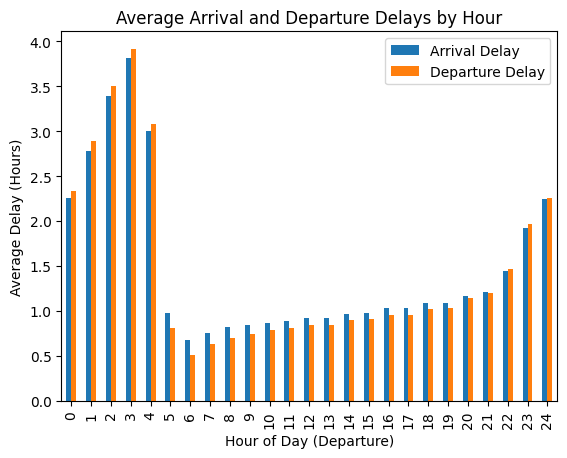

In [10]:
# 1
plt.figure(figsize=(10,5))
df.groupby('DepHour')[['ArrDelayHours', 'DepDelayHours']].mean().plot(kind='bar')
plt.title('Average Arrival and Departure Delays by Hour')
plt.xlabel('Hour of Day (Departure)')
plt.ylabel('Average Delay (Hours)')
plt.legend(['Arrival Delay', 'Departure Delay'])
plt.show()

## **Visualization 2**

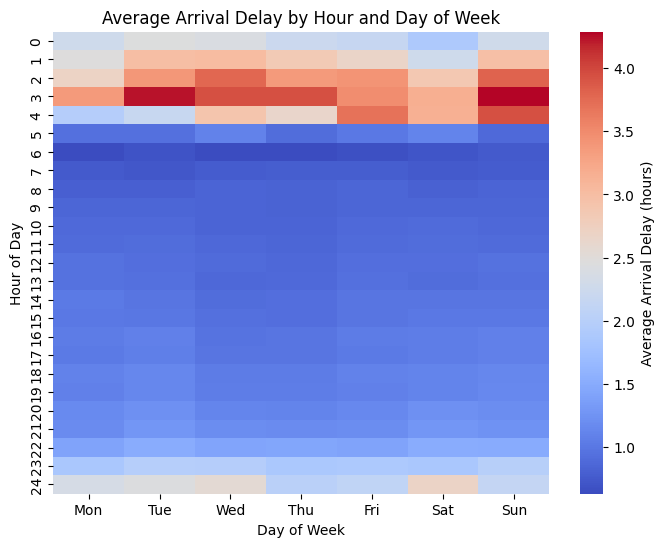

In [11]:
# 2
# Create pivot table for average arrival delay by weekday and hour
pivot = df.pivot_table(
    values='ArrDelayHours',
    index='DepHour',       # rows = hour of day
    columns='DayOfWeek',   # columns = day of week
    aggfunc='mean'
)

# Rename day columns for clarity
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(pivot, cmap='coolwarm', annot=False, cbar_kws={'label': 'Average Arrival Delay (hours)'})
plt.title('Average Arrival Delay by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

## **Visualization 3**

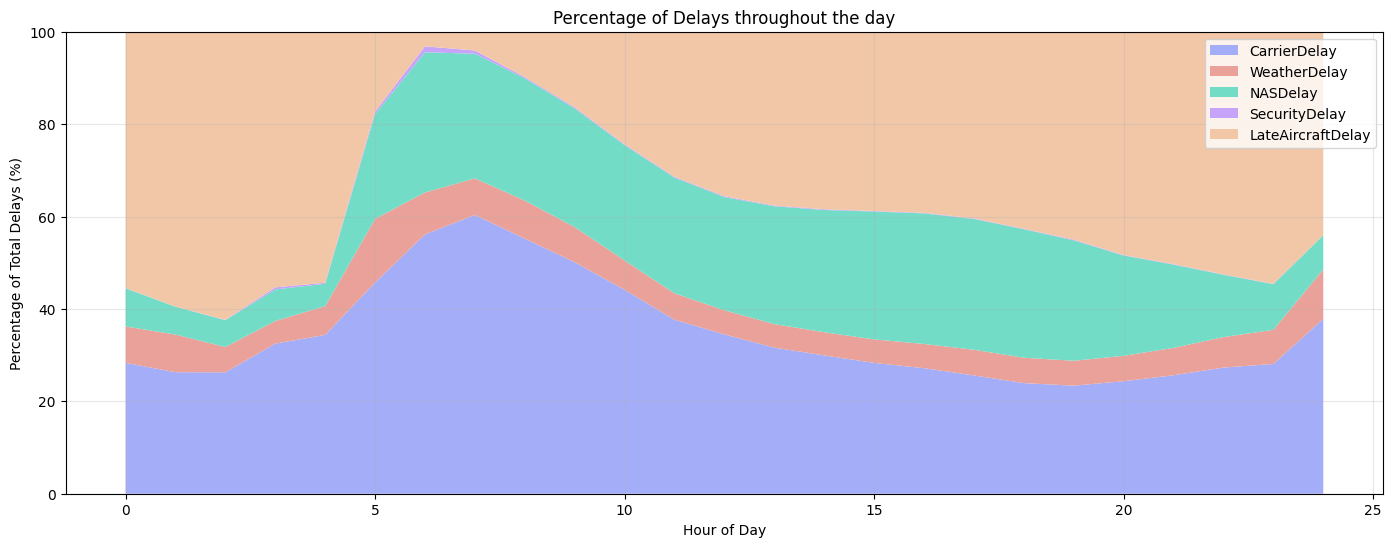

In [12]:
# 3
#group delay causes by hour and calculate sums
hourly_delays = df.groupby('DepHour')[DelayCause].sum()

#calculate percentages for each hour
hourly_percentages = hourly_delays.div(hourly_delays.sum(axis=1), axis=0) * 100

#create stacked area graph
plt.figure(figsize=(17, 6))
plt.stackplot(hourly_percentages.index,
              hourly_percentages['CarrierDelay'],
              hourly_percentages['WeatherDelay'],
              hourly_percentages['NASDelay'],
              hourly_percentages['SecurityDelay'],
              hourly_percentages['LateAircraftDelay'],
              labels=DelayCause,
              colors=['#A4ADF8', '#EAA199', '#72DCC6', '#C6A4F9', '#F2C7A8'])

plt.title('Percentage of Delays throughout the day')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage of Total Delays (%)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.show()

## **Visualization 4**

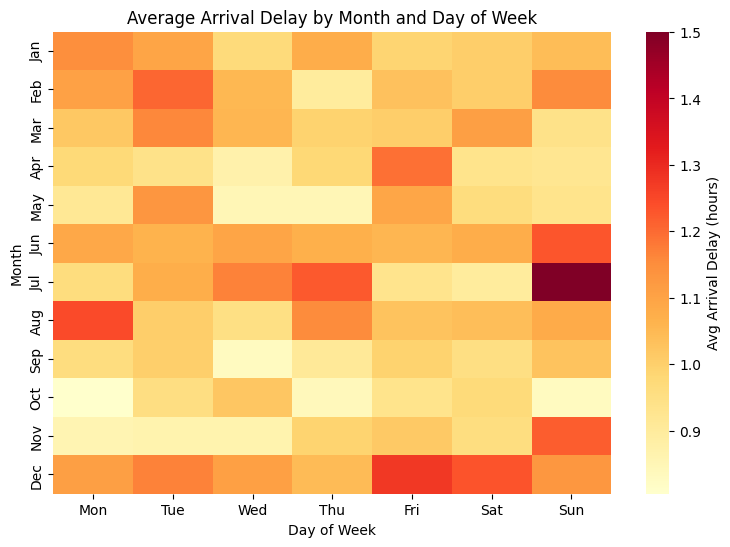

In [13]:
# 4
# Pivot table: average arrival delay grouped by month and weekday
pivot = df.pivot_table(
    values='ArrDelayHours',
    index='Month',        # months as rows
    columns='DayOfWeek',  # weekdays as columns
    aggfunc='mean'
)

# Replace numeric weekdays (1–7) with labels
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Replace numeric months (1–12) with short names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot.index = month_labels

# Plot heatmap
plt.figure(figsize=(9,6))
sns.heatmap(pivot, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Avg Arrival Delay (hours)'})
plt.title('Average Arrival Delay by Month and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Month')
plt.show()

## **Visualization 5**

In [14]:
# 5
# Sum delay causes by month (for all flights)
monthly_cause = df_raw.groupby('Month')[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']].sum()

# Calculate percentage of total delay minutes
monthly_percent = monthly_cause.div(monthly_cause.sum().sum(), axis=0) * 100

# Convert month numbers to names
monthly_percent = monthly_percent.reset_index()
monthly_percent['Month'] = monthly_percent['Month'].replace({
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
})

# Plot
fig = px.area(
    monthly_percent,
    x='Month',
    y=['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay'],
    title='Delay Causes by Month',
    labels={'value':'% of Total Delay Minutes', 'variable':'Delay Cause'}
)

fig.show()

## **Visualisation 6**

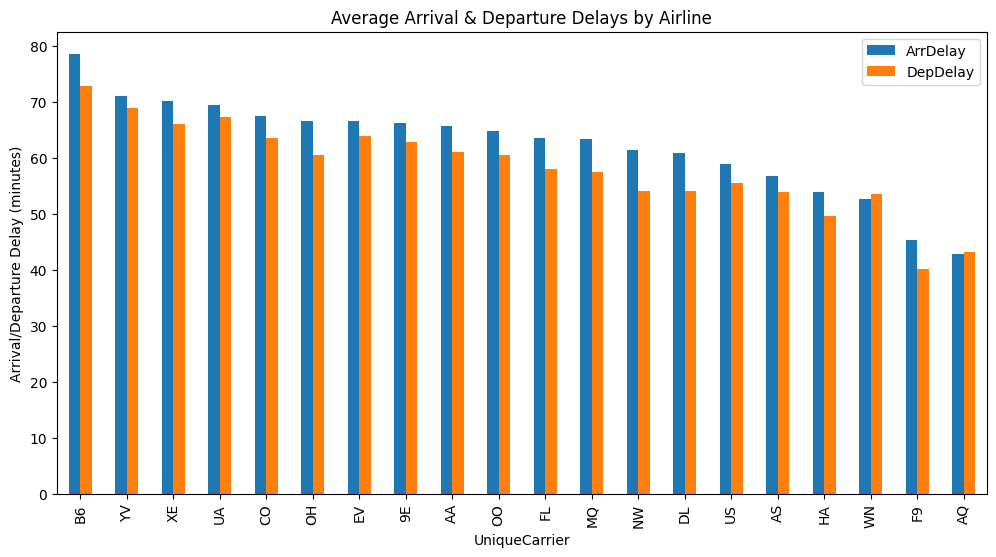

In [15]:
# 6
avg_delay_carrier = df.groupby('UniqueCarrier')[['ArrDelay','DepDelay']].mean().sort_values('ArrDelay', ascending=False)
avg_delay_carrier.plot(kind='bar', figsize=(12,6))
plt.title("Average Arrival & Departure Delays by Airline")
plt.ylabel("Arrival/Departure Delay (minutes)")
plt.show()